In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [12]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import classification_report, confusion_matrix

# Constants
# Replace with the actual path to your dataset
data_dir = 'chest_xray/chest_xray/'
labels = ['PNEUMONIA', 'NORMAL']
img_size = 64
num_epochs = 3
batch_size = 32

In [13]:
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Load the data for train, val, and test splits
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

train_data = get_data(train_dir)
val_data = get_data(val_dir)
test_data = get_data(test_dir)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 5216
Validation data size: 16
Test data size: 624


In [14]:
class ChestXrayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = np.array(image, dtype=np.uint8)
        
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        
        if self.transform:
            image = self.transform(image)
        return image, label

# REFINED TRANSFORMS to combat overfitting
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),  # <--- ADD THIS
    transforms.RandomRotation(30, fill=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3-channel normalization
])


val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create Dataset and DataLoader instances
train_dataset = ChestXrayDataset(train_data, transform=train_transforms)
val_dataset = ChestXrayDataset(val_data, transform=val_transforms)
test_dataset = ChestXrayDataset(test_data, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ======================
# 1. Load Pretrained ResNet18
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = models.resnet18(pretrained=True)

# Freeze all convolutional layers (like TF `layer.trainable=False`)
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# TF: GAP -> Dense(128, relu) -> Dense(1, sigmoid)
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),   # Binary classification
    nn.Sigmoid()         # Same as TF `activation='sigmoid'`
)

model = resnet18.to(device)

# ======================
# 2. Loss & Optimizer
# ======================
criterion = nn.BCELoss()  # Since we already applied Sigmoid in the model
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# ======================
# 3. Training Loop (simplified)
# ======================
num_epochs = 3
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation loop
    model.eval()
    running_val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


print("✅ Training complete with ResNet18 transfer learning")

Epoch [1/3], Train Loss: 0.3974, Train Accuracy: 82.48%, Val Loss: 0.6870, Val Accuracy: 56.25%
Epoch [2/3], Train Loss: 0.3315, Train Accuracy: 85.68%, Val Loss: 0.6397, Val Accuracy: 62.50%
Epoch [3/3], Train Loss: 0.3246, Train Accuracy: 86.16%, Val Loss: 0.6071, Val Accuracy: 68.75%
✅ Training complete with ResNet18 transfer learning


In [16]:
# Initial correct definition of labels
class_names = ['PNEUMONIA', 'NORMAL']

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    # Rename the loop variable to avoid overwriting the class_names variable
    for images, batch_labels in test_loader:
        images = images.to(device, dtype=torch.float)
        batch_labels = batch_labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float().cpu().numpy()
        y_true.extend(batch_labels.cpu().numpy())
        y_pred.extend(preds)

# Use the correctly named variable for the report
print(classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

   PNEUMONIA       0.83      0.83      0.83       390
      NORMAL       0.71      0.72      0.71       234

    accuracy                           0.79       624
   macro avg       0.77      0.77      0.77       624
weighted avg       0.79      0.79      0.79       624

Confusion Matrix:
 [[322  68]
 [ 66 168]]


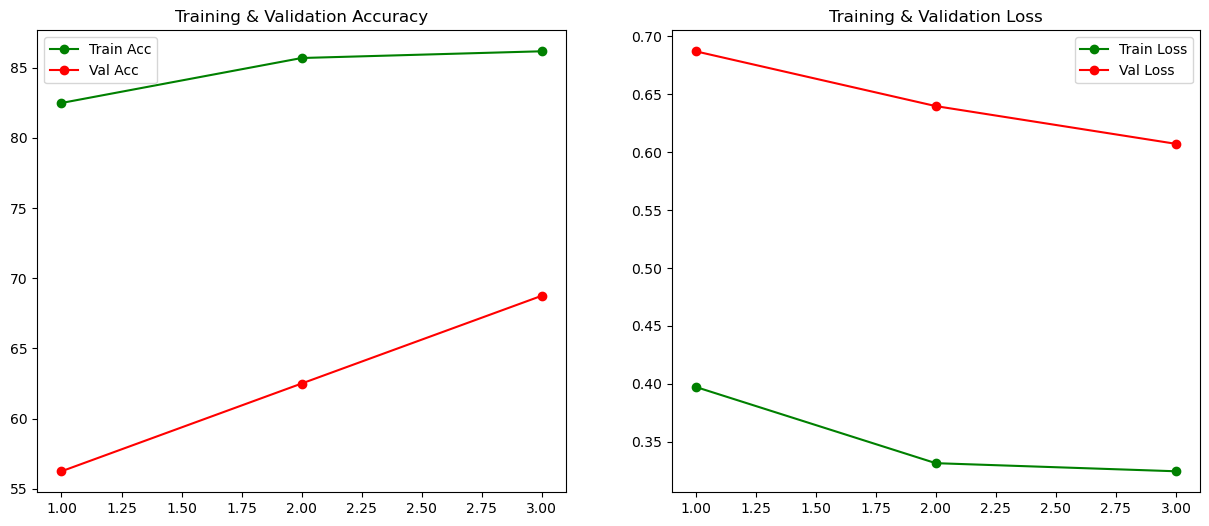

In [17]:
epochs = range(1, len(train_acc_history) + 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(epochs, train_acc_history, 'go-', label='Train Acc')
ax[0].plot(epochs, val_acc_history, 'ro-', label='Val Acc')
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()

ax[1].plot(epochs, train_loss_history, 'go-', label='Train Loss')
ax[1].plot(epochs, val_loss_history, 'ro-', label='Val Loss')
ax[1].set_title("Training & Validation Loss")
ax[1].legend()

plt.show()

In [18]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict=True)

print(report_dict)


{'0': {'precision': 0.8298969072164949, 'recall': 0.8256410256410256, 'f1-score': 0.8277634961439588, 'support': 390.0}, '1': {'precision': 0.711864406779661, 'recall': 0.717948717948718, 'f1-score': 0.7148936170212766, 'support': 234.0}, 'accuracy': 0.7852564102564102, 'macro avg': {'precision': 0.770880656998078, 'recall': 0.7717948717948717, 'f1-score': 0.7713285565826178, 'support': 624.0}, 'weighted avg': {'precision': 0.785634719552682, 'recall': 0.7852564102564102, 'f1-score': 0.7854372914729529, 'support': 624.0}}


In [23]:
import mlflow
import mlflow.pytorch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ===============================
# 1. Generate predictions
# ===============================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).int()  # convert predictions to integers
        y_true.extend(labels.cpu().numpy().astype(int))
        y_pred.extend(preds.cpu().numpy().flatten().astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ===============================
# 2. Classification report
# ===============================
class_names = ['PNEUMONIA', 'NORMAL']  # adjust to your dataset
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ===============================
# 3. MLflow Logging
# ===============================
mlflow.set_tracking_uri("http://127.0.0.1:8000/")
mlflow.set_experiment("resnet")

params = {"epochs": 3, "batch_size": 32, "optimizer": "Adam"}

with mlflow.start_run():
    mlflow.log_params(params)

    # log metrics for each class and macro
    for i, cls in enumerate(class_names):
        mlflow.log_metric(f"recall_{cls}", report_dict[cls]['recall'])
        mlflow.log_metric(f"precision_{cls}", report_dict[cls]['precision'])
        mlflow.log_metric(f"f1_{cls}", report_dict[cls]['f1-score'])

    # log overall metrics
    mlflow.log_metric("accuracy", report_dict["accuracy"])
    mlflow.log_metric("f1_score_macro", report_dict["macro avg"]["f1-score"])
    mlflow.log_metric("precision_macro", report_dict["macro avg"]["precision"])
    mlflow.log_metric("recall_macro", report_dict["macro avg"]["recall"])

    # log the PyTorch model
    mlflow.pytorch.log_model(model, "resnet_model")

print("✅ MLflow logging complete")


2025/09/23 22:50:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Classification Report:
               precision    recall  f1-score   support

   PNEUMONIA       0.83      0.83      0.83       390
      NORMAL       0.71      0.72      0.71       234

    accuracy                           0.79       624
   macro avg       0.77      0.77      0.77       624
weighted avg       0.79      0.79      0.79       624

Confusion Matrix:
 [[322  68]
 [ 66 168]]


2025/09/23 22:50:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run welcoming-snipe-588 at: http://127.0.0.1:8000/#/experiments/913000521377215982/runs/7b07936568b14f7ab38fbd9339adddbf
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/913000521377215982
✅ MLflow logging complete
